In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
#from sklearn.cross_validation import train_test_split  #LAE: sklearn changed package name
from sklearn.model_selection import train_test_split #LAE: added

%matplotlib inline
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
def plot_data(data, x, y, x_title='x', y_title='y', xlim=None, ylim=None, size=4, alpha=0.02):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x],data[y])
    print '# of UTRs = ', len(data)
    print 'r-squared = ',r_value**2

    sns.set(style="ticks", color_codes=True)
    g = sns.JointGrid(data=data, x=x, y=y, xlim=xlim, ylim=ylim, size=size)
    g = g.plot_joint(plt.scatter, color='#e01145', edgecolor="black", alpha=alpha)
    f = g.fig
    f.text(x=0, y=0, s='r2 = {}'.format(round(r_value**2, 3)))
    g = g.plot_marginals(sns.distplot, kde=False, color='#e01145')
    g = g.set_axis_labels(x_title, y_title)
    
def vectorizeSequence(seq):
    # the order of the letters is not arbitrary.
    # Flip the matrix up-down and left-right for reverse compliment
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    return np.array([ltrdict[x] for x in seq])

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, EarlyStopping

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    #df.loc[:,'obs_stab'] = test_df['stab_df']
    predictions = model.predict(test_seq).reshape(-1)
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def binarize_sequences(df, col='utr', seq_len=54):
    vector=np.empty([len(df),seq_len,4])
    for i,seq in enumerate(df[col].str[:seq_len]):
        vector[i]=vectorizeSequence(seq.lower())
    return vector

Using TensorFlow backend.


### Load data to get MRL values for scaling - convert the scaled predictions of the evolved sequences to MRL

In [2]:
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', ascending=False).reset_index(drop=True)

# Select a number of UTRs for the purpose of scaling.
scale_utrs = df[:40000]

# Scale
scaler = preprocessing.StandardScaler()
scaler.fit(scale_utrs['rl'].values.reshape(-1,1)) #LAE: added .values for pd deprecation

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Choose model to use for evolving new sequences.
In the paper, the model used for evolving sequences is saved here as "evolution_model.hdf5". This is an older model that predates the main egfp model used in the paper (trained on unmodified EGFP replicate #1). The main model used in the paper is labeled "main_MRL_model.hdf5". Both retrained models are also available.

In [3]:
from keras.models import load_model
# model = load_model('../modeling/saved_models/evolution_model.hdf5')
# model = load_model('../modeling/saved_models/retrained_evolution_model.hdf5')
# model = load_model('../modeling/saved_models/main_MRL_model.hdf5')
model = load_model('../modeling/saved_models/retrained_main_MRL_model.hdf5')

W0719 15:03:24.207288 4458436032 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 15:03:24.229902 4458436032 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 15:03:24.235105 4458436032 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 15:03:24.366743 4458436032 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 15:03:24.379096 4458436032 deprecati

### Genetic algorithm

In [4]:
import random
import math

def ret_rand_nuc():
    x = random.randint(0,3)
    if x == 0:
        return [1,0,0,0] # A
    if x == 1:
        return [0,1,0,0] # C
    if x == 2:
        return [0,0,1,0] # G
    if x == 3:
        return [0,0,0,1] # T
    
def vector_to_nuc(arr, seq_len=50):
    seq = ''
    for i in range(seq_len):
        if arr[i,0] == 1:
            seq = seq + 'A'
        if arr[i,1] == 1:
            seq = seq + 'C'
        if arr[i,2] == 1:
            seq = seq + 'G'
        if arr[i,3] == 1:
            seq = seq + 'T'
    return seq

def convert_and_save(sequences, predictions):
    # Convert the one-hot encoded sequences to A, C, T, G
    seqs = []
    for nbr in xrange(len(sequences)):
        seqs.append(vector_to_nuc(sequences[nbr]))
    df = pd.DataFrame(data=[seqs,predictions.tolist()]).transpose()
    df.columns = ['utr', 'prediction']
    df.sort_values('prediction', ascending=False, inplace=True)
    return df

def make_random_sequences(nbr_sequences, length, constant='', no_uaug=False, no_stop=False):
    # Make randomize sequences, allowing for the inclusion / exclusion of uATGs / stop codons
    seqs = []
    nucs = {0:'A', 1:'T', 2:'C', 3:'G'}
    i = 0
    while i < nbr_sequences:
        new_seq = ''
        for n in range(length - len(constant)):
            new_seq = new_seq + nucs[random.randint(0,3)]
        
        if no_uaug == False or (no_uaug==True and 'ATG' not in new_seq):
            if no_stop == False or (no_stop == True and ('TAG' not in new_seq and 'TGA' not in new_seq and 'TAA' not in new_seq)):
                new_seq = new_seq + constant
                seqs.append(new_seq)
                i+=1
    return seqs

def simple_mutate(seq, nbr_bases=1, prob=1):
    if nbr_bases > 1 and prob > random.random():
        nbr_bases = nbr_bases
    else:
        nbr_bases = 1
    for i in range(nbr_bases):
        pos = random.randint(0, 49)
        seq[pos] = ret_rand_nuc()
    return seq

def check_for_uaug(seq):
    seq = vector_to_nuc(seq)
    return 'ATG' in seq[:50]

def check_for_stops(seq):
    seq = vector_to_nuc(seq)
    if 'TAG' in seq[:50] or 'TGA' in seq[:50] or 'TAA' in seq[:50]:
        return True
    return False

def negative_selection(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1, seq_len=50):
    seqs = np.empty([2,seq_len,4])
    seqs[0] = seq.copy()
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    if scores[1] < scores[0]:
        if scores[1] >= target_val:
            return seqs[1]
        else:
            return seqs[0]
    else:
        return seqs[0]    

def selection(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1, seq_len=50):
    seqs = np.empty([2, seq_len, 4])
    seqs[0] = seq.copy()
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    if scores[1] > scores[0]:
        if scores[1] <= target_val:
            return seqs[1]
        else:
            return seqs[0]
    else:
        return seqs[0]    
    
def selection_to_target(seq, model, scaler, target_val, no_uaug=False, no_stop=False, nbr_bases_to_mutate=1, multi_mutate_prob=1, seq_len=50, accept_range=0.1):
    seqs = np.empty([2,seq_len,4])
    # Save the incoming sequence before mutating
    seqs[0] = seq.copy()
    # The mutated sequence
    seqs[1] = simple_mutate(seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=multi_mutate_prob)
    
    # Decide whether to continue with the new sequence based on the uAUG / stop codon preference
    if no_uaug == True and check_for_uaug(seqs[1]):
        return seqs[0]
    if no_stop == True and check_for_stops(seqs[1]):
        return seqs[0]
    
    scores = model.predict(seqs).reshape(-1)
    scores = scaler.inverse_transform(scores)
    
    # Accept sequences that fall within this range. May provide more sequence diversity
    if scores[0] >= target_val - accept_range and scores[0] <= target_val + accept_range:
        return seqs[0]
    else:
        if abs(target_val - scores[1]) <= abs(target_val - scores[0]):
            return seqs[1]
        else:
            return seqs[0]    

_____

### Evolve new sequences - random to worst to best

In [5]:
# Dictionary where new sequences are saved
evolved_seqs = {}
# Number of evolution iterations
iterations = 100
# Number of bases to mutate if the probability to 'multi-mutate' is exceeded
nbr_bases_to_mutate = 2
# Probability to change multiple bases in an iteration
prob_of_multi_mutation = 0.5
# If using the original evolution model, set seq_len to 54. That model was
# trained on UTRs that included the first for basees of the CDS (ATGG).
seq_len = 50
# Choose whether or not to allow uAUGs and / or stop codons
no_uaug = True
no_stop = False

nbr_sequences = 5
rand_seqs = make_random_sequences(nbr_sequences, seq_len, no_uaug=True, no_stop=True)
e_seqs = np.empty([len(rand_seqs), seq_len, 4])

i = 0
for seq in rand_seqs:
    e_seqs[i]=vectorizeSequence(seq.lower())
    i += 1

for x in range(nbr_sequences):
    evolved_seqs[x] = np.empty((iterations*2,2), dtype=object)

for gen in range(0, iterations*2):
    for i in range(len(e_seqs)):
        if gen < iterations:
            # Evolve for lowest MRL
            target_rl = 0
            e_seqs[i] = negative_selection(seq=e_seqs[i], model=model, scaler=scaler, target_val=target_rl, no_uaug=no_uaug,
                                    no_stop=no_stop, nbr_bases_to_mutate=nbr_bases_to_mutate, multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)
        else:
            # Evolve to highest MRL - set target_rl to arbitrarily high value
            target_rl = 20
            e_seqs[i] = selection(seq=e_seqs[i], model=model, scaler=scaler, target_val=target_rl,no_uaug=no_uaug,
                                    no_stop=no_stop, nbr_bases_to_mutate=nbr_bases_to_mutate, multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)
    
    for x in range(nbr_sequences):
        evolved_seqs[x][gen, 0] = vector_to_nuc(e_seqs[x])
        evolved_seqs[x][gen, 1] = model.predict(e_seqs).reshape(-1)[x]
    
    if gen % 100 == 0:
        print gen,

for x in range(nbr_sequences):
    evolved_seqs[x][:,1] = scaler.inverse_transform(evolved_seqs[x][:, 1])

0 100


### Plot

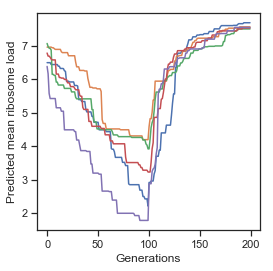

In [6]:
for x in range(nbr_sequences)[:5]:
    plt.plot(range(evolved_seqs[0].shape[0]), evolved_seqs[x][:,1])
plt.xlabel('Generations')
plt.ylabel('Predicted mean ribosome load')
plt.gcf().set_size_inches((4,4))

##### Now get rid of steps where the sequence didn't change, make a dataframe and store in a dictionary.

In [7]:
wb_seqs = {}
count = 0
for x in range(len(evolved_seqs)):
    tmp = pd.DataFrame(evolved_seqs[x], columns=['seq', 'pred_rl'])
    tmp['generation'] = tmp.index
    tmp = tmp.drop_duplicates(subset=['seq'])
    tmp.reset_index(inplace=True, drop=True)
    wb_seqs[x] = tmp
    count += len(tmp)
print count

286


________________

### Evolving random to best

In [8]:
nbr_sequences = 20
rand_seqs = make_random_sequences(nbr_sequences, 54, 'ATGG', no_uaug=True, no_stop=True)
test_sequences = np.empty([len(rand_seqs),54,4])

i = 0
for seq in rand_seqs:
    test_sequences[i]=vectorizeSequence(seq.lower())
    i += 1

scaler = preprocessing.StandardScaler()
scaler.fit(scale_utrs['rl'].values.reshape(-1,1)) #LAE: got 1D/2D error, added .values.reshape(-1,1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
# Dictionary where new sequences are saved
evolved_seqs = {}
# Number of evolution iterations
iterations = 100
# Number of bases to mutate if the probability to 'multi-mutate' is exceeded
nbr_bases_to_mutate = 2
# Probability to change multiple bases in an iteration
prob_of_multi_mutation = 0.5
# If using the original evolution model, set seq_len to 54. That model was
# trained on UTRs that included the first for basees of the CDS (ATGG).
seq_len = 50
# Choose whether or not to allow uAUGs and / or stop codons
no_uaug = True
no_stop = False

nbr_sequences = 5
rand_seqs = make_random_sequences(nbr_sequences, seq_len, no_uaug=True, no_stop=True)
e_seqs = np.empty([len(rand_seqs), seq_len, 4])

i = 0
for seq in rand_seqs:
    e_seqs[i]=vectorizeSequence(seq.lower())
    i += 1

for x in range(nbr_sequences):
    evolved_seqs[x] = np.empty((iterations,2), dtype=object)

for gen in range(0, iterations):
    for i in range(len(e_seqs)):
        # Evolve to highest MRL - set target_rl to arbitrarily high value
        target_rl = 20
        e_seqs[i] = selection(seq=e_seqs[i], model=model, scaler=scaler, target_val=target_rl,no_uaug=no_uaug,
                                no_stop=no_stop, nbr_bases_to_mutate=nbr_bases_to_mutate, multi_mutate_prob=prob_of_multi_mutation, seq_len=seq_len)
    
    for x in range(nbr_sequences):
        evolved_seqs[x][gen, 0] = vector_to_nuc(e_seqs[x])
        evolved_seqs[x][gen, 1] = model.predict(e_seqs).reshape(-1)[x]
    
    if gen % 100 == 0:
        print gen,

for x in range(nbr_sequences):
    evolved_seqs[x][:,1] = scaler.inverse_transform(evolved_seqs[x][:, 1])

 0


### Plot

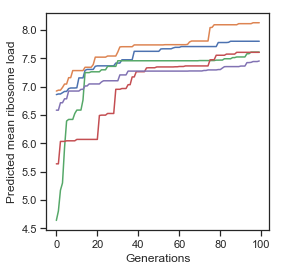

In [14]:
for x in range(nbr_sequences)[:5]:
    plt.plot(range(evolved_seqs[0].shape[0]), evolved_seqs[x][:,1])
plt.xlabel('Generations')
plt.ylabel('Predicted mean ribosome load')
plt.gcf().set_size_inches((4,4))

In [15]:
rb_seqs = {}
count = 0
for x in range(len(evolved_seqs)):
    tmp = pd.DataFrame(evolved_seqs[x], columns=['seq', 'pred_rl'])
    tmp['generation'] = tmp.index
    tmp = tmp.drop_duplicates(subset=['seq'])
    tmp.reset_index(inplace=True, drop=True)
    rb_seqs[x] = tmp
    count += len(tmp)
print count

117
